<a href="https://colab.research.google.com/github/Coreight98/Paran_ajou_Project_Anything/blob/main/%EC%9D%B8%EA%B0%84%EC%A7%80%EB%8A%A53.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import PIL
import time
from sklearn.neighbors import KNeighborsClassifier

cuda 로 학습
--Train Images--
Num of All Images:  4024
Num of Beds Images:  900
Num of chairs Images:  900
Num of sofas Images:  900
Num of swivelchairs Images:  900
Num of tables Images:  424
9999
[[  57   73  183  257 1678 1679 1777 1789 1865 3973]]
[[[2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [1]]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


swivelchair
swivelchair
swivelchair
swivelchair
sofa
sofa
swivelchair
swivelchair
swivelchair
chair
accuracy :  0.7


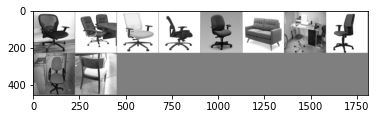

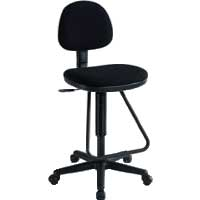

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (device,"로 학습")

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

train_location = './drive/MyDrive/data/img/train/'
# test_location = './drive/MyDrive/data/img/val/'

X = np.empty((0, 4), dtype=int)
Y = np.empty((0, 1), dtype=int)
I=0
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=2,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=2,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # 세번째층
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=2,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # 네번째층
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=2,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=3))
        
        # 다섯번째층
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=2,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=3))

        # 6번째층
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=2,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=3))
        
        # 전결합층 
        self.fc = torch.nn.Linear(512, 5, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        global X,I
        out = self.layer1(x)
      
        out = self.layer2(out)
   
        out = self.layer3(out)
     
        out = self.layer4(out)

        out = self.layer5(out)
        
        out = self.layer6(out)
        
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        if I<4024:
          X = np.append(X,out.detach().numpy())
          I+=1
        print(I)
        return out

class FurnitureDataset():
    def __init__(self, image, class_to_int, mode, transforms):
        super().__init__()
        self.image = image
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, index):
        image_name = self.image[index]
        image = Image.open(train_location + image_name)
        image = image.resize((224,224))

        
        #레이블 입력
        global Y
        label = self.class_to_int[image_name.split('.')[0]]
        label = torch.tensor(label,dtype=torch.long)
        Y = np.append(Y,label)
        #이미지 변형 적용
        image = self.transforms(image)
        return image, label
       

    def __len__(self):
        return len(self.image)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

if __name__ == '__main__':
    #데이터 셋 불러오고 정규화
    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor(),
          transforms.Normalize((0.5),(0.5))
          ]
    )
    
    train_images = os.listdir(train_location)
    # test_images = os.listdir(test_location)
    print("--Train Images--")
    print("Num of All Images: ", len(train_images))
    beds_list = [img for img in train_images if img.split(".")[0] == "bed"]
    chairs_list = [img for img in train_images if img.split(".")[0] == "chair"]
    sofas_list = [img for img in train_images if img.split(".")[0] == "sofa"]
    swivelchair_list = [img for img in train_images if img.split(".")[0] == "swivelchair"]
    tables_list = [img for img in train_images if img.split(".")[0] == "table"]
    print("Num of Beds Images: ", len(beds_list))
    print("Num of chairs Images: ", len(chairs_list))
    print("Num of sofas Images: ", len(sofas_list))
    print("Num of swivelchairs Images: ", len(swivelchair_list))
    print("Num of tables Images: ", len(tables_list))

    # # 레이블 구분
    class_to_int = {"bed": 0, "chair": 1, "swivelchair": 2, "sofa": 3, "table": 4}
    int_to_class = {0: "bed", 1: "chair", 2: "swivelchair", 3: "sofa", 4: "table"}
    classes = ['bed', 'chair', 'swivelchair', 'sofa', 'table']

    # # 데이터 셋 생성
    train_dataset = FurnitureDataset(train_images, class_to_int, mode='train', transforms=transform)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=0)
    
    # net = CNN()
    
    

    # # # #신경망 학습하기
    # for i, data in enumerate(trainloader,0):
    #     inputs, labels = data  # data입력
    #     outputs = net(inputs)

    # np.save('./drive/MyDrive/data/accuracy5.npy', X)
    # np.save('./drive/MyDrive/data/accuracy5_label.npy', Y)

    # print('Finished Training')
    PATH = './drive/MyDrive/data/accuracy5_net.pth'
    # torch.save(net, PATH)


######################################################################

    net = torch.load(PATH)
    net.eval()
    
    X = np.load('./drive/MyDrive/data/accuracy5.npy')
    Y = np.load('./drive/MyDrive/data/accuracy5_label.npy')
    # # print(X)
    I=9999
    img=PIL.Image.open('./drive/MyDrive/data/img/train/swivelchair.10.jpg')
    input_label = class_to_int["swivelchair"]
    img = img.resize((224,224))
    emp = torch.empty(1,1,224,224)
    img_t =transform(img)
    emp[0] = img_t
    input = net(emp)

    X = np.reshape(X,(4024,5)) #1281개 5개tensor\
    Y = np.reshape(Y,(4024,1))
    # Y = np.ones((4024,1),dtype=int)

    reg = KNeighborsClassifier(n_neighbors=10)
    reg.fit(X,Y)
    neighbor_index= reg.kneighbors(input.detach().numpy(),n_neighbors=10,return_distance=False)
    
    neighbor_index.sort()
    print(neighbor_index)
    for i in neighbor_index:
      # print(int_to_class[Y[neighbor_index]])
      print(Y[neighbor_index])

    for i in neighbor_index:
      temp = np.empty((0,5),dtype=int)
      temp = np.append(temp, X[i])
    temp = np.reshape(temp,(10,5))
    
    

    dataiter = iter(trainloader)
    count = 0
    
    index=0
    
    images = torch.empty(10,1,224,224)

    correct=0
    while(index<10):
      if count < neighbor_index[0][index]:
        imgg=img
        img=dataiter.next()
        count+=4
      else:
        # print("find!")
        #l[0][index]-count 한 값을 인덱스로 dataiter에서 출력
        k=count-neighbor_index[0][index]
        if k == 0:
          images[index][0] = img[0][k][0]
          label=classes[img[1][k].item()]
          print(label)
          if img[1][k].item()==input_label:
            correct+=1
        else:
          images[index][0] = imgg[0][4-k][0]
          label=classes[img[1][4-k].item()]
          print(label)
          if img[1][4-k].item()==input_label:
            correct+=1
        count+=4
        index+=1
        if index != 4:
          dataiter.next()
    print("accuracy : ",correct/10)

    #이미지 출력
    imshow(torchvision.utils.make_grid(images))

    from IPython.display import Image 
    img=Image('./drive/MyDrive/data/img/train/swivelchair.10.jpg')
    display(img)
    from PIL import Image